In [1]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffrax
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
from models.manual_implementations.glycolysis.glycolysis_model import *

jax.config.update("jax_enable_x64", True)
from source.parameter_estimation.training import create_log_params_means_centered_loss_func2,log_transform_parameters,exponentiate_parameters
from scripts.analysis_helper_functions.helper_function_glycolysis_analysis import overwrite_y0_dict,prepare_glycolysis_model,update_parameters_by_dilution_rate,divide_parameters_by_dilution_rate

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes
n_parameters 141


In [2]:
expression_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/PvanHoekExpressionData.csv",index_col=0)

column_pairs = [
    ('D_HXK', 'HXK'),('D_PGI', 'PGI'),
    ('D_PFK', 'PFK'),('D_FBA', 'FBA'),
    ('D_TPI', 'TPI'),('D_GAPDH', 'GAPDH'),
    ('D_PGK', 'PGK'),('D_PGM', 'PGM'),
    ('D_ENO', 'ENO'),('D_PYK', 'PYK'),
    ('D_PDC', 'PDC'),('D_ADH', 'ADH')]

interpolation_expression_dict = {}

Ds=jnp.linspace(0,0.375,100)

for D_col, col in column_pairs:
    interp_key=f"expr_interpolated_{col}"
    interpolation_expression_dict[interp_key] = diffrax.LinearInterpolation(ts=jnp.array(expression_data[D_col]),ys=jnp.array(expression_data[col]))


In [3]:
y0_dict={'ICG1P':0.064568,
         "ICT6P":0.093705,
         "ICtreh":63.312040,
         'ICglucose':0.196003,
         'ICG6P':0.716385,
         'ICF6P':0.202293,
         "ICFBP":0.057001,
         "ICDHAP":0.048571,
         "ICG3P":0.020586,
         "ICglyc":0.1,
         "ICGAP":0.006213,
         "ICBPG":0.0001,
         "IC3PG":2.311074,
         "IC2PG":0.297534,
          "ICPEP":1.171415,
          "ICPYR":0.152195,
          "ICACE":0.04,
          "ICETOH":10.0,
          "ICNADH":0.0106,
          "ICNAD":1.5794,
          "ICATP":3.730584,
          "ICADP":1.376832,
          "ICAMP":0.431427,
          "ICPHOS":10,
          "ICIMP":0.100,
          "ICINO":0.100,
          "ICHYP":1.5,
          }
y0=jnp.array(list(y0_dict.values()))
metabolite_names=list(y0_dict.keys())

# glycolyse=glycolysis(interpolated_mets,metabolite_names,dilution_rate=0.1)
# term=diffrax.ODETerm(glycolyse)
# dataset1=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF1_timeseries_format.csv",index_col=0).T
# time_points=[int(i) for i in dataset1.index.to_list()]


In [4]:
#input y0



glycolyse_GP1,time_points_GP1,y0_GP1,dataset_GP1=prepare_glycolysis_model(data_type="glucose_pulse",dilution_rate="0.1",y0_dict=y0_dict)
glycolyse_SS_01,time_points_SS_01,y0_SS_01,dataset_SS_01=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.02",y0_dict=y0_dict)
glycolyse_SS_05,time_points_SS_05,y0_SS_05,dataset_SS_05=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.05",y0_dict=y0_dict)
glycolyse_SS_10,time_points_SS_10,y0_SS_10,dataset_SS_10=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.1",y0_dict=y0_dict)
glycolyse_SS_20,time_points_SS_20,y0_SS_20,dataset_SS_20=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.2",y0_dict=y0_dict)
glycolyse_SS_30,time_points_SS_30,y0_SS_30,dataset_SS_30=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.3",y0_dict=y0_dict)
glycolyse_SS_325,time_points_SS_325,y0_SS_325,dataset_SS_325=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.325",y0_dict=y0_dict)
glycolyse_SS_35,time_points_SS_35,y0_SS_35,dataset_SS_35=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.35",y0_dict=y0_dict)
glycolyse_SS_375,time_points_SS_375,y0_SS_375,dataset_SS_375=prepare_glycolysis_model(data_type="steady_state",dilution_rate="0.375",y0_dict=y0_dict)


#

In [5]:
datasets={"GP1":jnp.array(dataset_GP1),"SS_01":jnp.array(dataset_SS_01),"SS_05":jnp.array(dataset_SS_05),
          "SS_10":jnp.array(dataset_SS_10),"SS_20":jnp.array(dataset_SS_20),"SS_30":jnp.array(dataset_SS_30),
          "SS_325":jnp.array(dataset_SS_325),"SS_35":jnp.array(dataset_SS_35),"SS_375":jnp.array(dataset_SS_375)}

time_points={"GP1":jnp.array(time_points_GP1),"SS_01":jnp.array(time_points_SS_01),"SS_05":jnp.array(time_points_SS_05),
          "SS_10":jnp.array(time_points_SS_10),"SS_20":jnp.array(time_points_SS_20),"SS_30":jnp.array(time_points_SS_30),
          "SS_325":jnp.array(time_points_SS_325),"SS_35":jnp.array(time_points_SS_35),"SS_375":jnp.array(time_points_SS_375)}

In [6]:
loss_targets_glucose_pulse=[0,1,2,
                            4,5,6,10,12,14,20,21,22]
loss_targets_steady_state=[4,5,6,7,10,12,13,14,15,17,20,21,22]

log_loss_func_GP1=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_GP1,loss_targets_glucose_pulse))
log_loss_func_SS_01=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_01,loss_targets_steady_state))
log_loss_func_SS_05=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_05,loss_targets_steady_state))
log_loss_func_SS_10=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_10,loss_targets_steady_state))
log_loss_func_SS_20=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_20,loss_targets_steady_state))
log_loss_func_SS_30=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_30,loss_targets_steady_state))
log_loss_func_SS_325=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_325,loss_targets_steady_state))
log_loss_func_SS_35=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_35,loss_targets_steady_state))
log_loss_func_SS_375=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_SS_375,loss_targets_steady_state))




In [7]:
# params_after_fitting=pd.read_csv("results/EXP4_Glycolysis_Fitting_Datasets/0909_params_gradient_descent_federated.csv",index_col=0).to_dict()['0']
# params=params_after_fitting


lr=1e-3

optimizer = optax.adabelief(lr)
clip_by_global=optax.clip_by_global_norm(np.log(4))
optimizer = optax.chain(optimizer,clip_by_global)
opt_state = optimizer.init(params)
params_init=params



loss_per_iter1=[]
loss_per_iter2=[]
loss_per_iter3=[]
loss_per_iter4=[]
loss_per_iter5=[]
loss_per_iter6=[]
loss_per_iter7=[]
loss_per_iter8=[]
loss_per_iter9=[]



In [8]:
grads_GP1=jax.jit(jax.grad(log_loss_func_GP1,0))
grads_SS_01=jax.jit(jax.grad(log_loss_func_SS_01,0))
grads_SS_05=jax.jit(jax.grad(log_loss_func_SS_05,0))
grads_SS_10=jax.jit(jax.grad(log_loss_func_SS_10,0))
grads_SS_20=jax.jit(jax.grad(log_loss_func_SS_20,0))
grads_SS_30=jax.jit(jax.grad(log_loss_func_SS_30,0))
grads_SS_325=jax.jit(jax.grad(log_loss_func_SS_325,0))
grads_SS_35=jax.jit(jax.grad(log_loss_func_SS_35,0))
grads_SS_375=jax.jit(jax.grad(log_loss_func_SS_375,0))


### Gradient descent on multiple datasets
We have multiple datasets that have some dilution rate dependencies. However we expect that the kcat is consistent between datasets. We need to therefore first update parameters for the different dilution rates and then calculate the loss function. We then have to calculate the gradient in the same way as before. We then simply use the gradients on the pre-transformed parameters as an update rule. 

In [9]:

ys=datasets
ts=time_points

for step in range(200):
    
    grads={}

    log_params=log_transform_parameters(params_init) #not used to calculate gradients, but is updated in line 57 (optax apply updates)
    log_params_01=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.01))
    log_params_05=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.05))
    log_params_10=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.1))
    log_params_20=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.2))
    log_params_30=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.3))
    log_params_325=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.325))
    log_params_35=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.35))
    log_params_375=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.375))



    ## gradients are calculated for the update parameters
    loss1=log_loss_func_GP1(log_params_10,ts['GP1'],ys['GP1'])
    grads1=grads_GP1(log_params_10,ts['GP1'],ys['GP1'])

    loss2=log_loss_func_SS_01(log_params_01,ts['SS_01'],ys['SS_01'])
    grads2=grads_SS_01(log_params_01,ts['SS_01'],ys['SS_01'])

    loss3=log_loss_func_SS_05(log_params_05,ts['SS_05'],ys['SS_05'])
    grads3=grads_SS_05(log_params_05,ts['SS_05'],ys['SS_05']) 

    loss4=log_loss_func_SS_10(log_params_10,ts['SS_10'],ys['SS_10'])
    grads4=grads_SS_10(log_params_10,ts["SS_10"],ys['SS_10']) 

    loss5=log_loss_func_SS_20(log_params_20,ts['SS_20'],ys['SS_20'])
    grads5=grads_SS_20(log_params_20,ts['SS_20'],ys['SS_20'])

    loss6=log_loss_func_SS_30(log_params_30,ts['SS_30'],ys['SS_30'])
    grads6=grads_SS_30(log_params_30,ts['SS_30'],ys['SS_30'])

    loss7=log_loss_func_SS_325(log_params_325,ts['SS_325'],ys['SS_325'])
    grads7=grads_SS_325(log_params_325,ts['SS_325'],ys['SS_325'])

    loss8=log_loss_func_SS_35(log_params_35,ts['SS_35'],ys['SS_35'])
    grads8=grads_SS_35(log_params_35,ts['SS_35'],ys['SS_35'])

    loss9=log_loss_func_SS_375(log_params_375,ts['SS_375'],ys['SS_375'])
    grads9=grads_SS_375(log_params_375,ts['SS_375'],ys['SS_375'])

    #Gradients are averaged 
    for key in grads1.keys():
        grads[key]=(grads1[key]+grads2[key]+grads3[key]+grads4[key])/4#+grads5[key]+grads6[key]+grads7[key]+grads8[key]+grads9[key])/9


    # we perform the updataset
    updates,opt_state=optimizer.update(grads,opt_state)
    #we perform updates in log space, but only return params in lin space
    log_params = optax.apply_updates(log_params, updates)
    lin_params = exponentiate_parameters(log_params) 
    params_init=lin_params

    loss_per_iter1.append(float(loss1))
    loss_per_iter2.append(float(loss2))
    loss_per_iter3.append(float(loss3))
    loss_per_iter4.append(float(loss4))
    loss_per_iter5.append(float(loss5))
    loss_per_iter6.append(float(loss6))
    loss_per_iter7.append(float(loss7))
    loss_per_iter8.append(float(loss8))
    loss_per_iter9.append(float(loss9))



    if step% 20==0:
        print(f"Step {step}, Loss {loss1+loss2+loss3+loss4+loss5+loss6+loss7+loss8+loss9}")




In [34]:
losses_per_iterations={"loss_per_iter1":loss_per_iter1,"loss_per_iter2":loss_per_iter2,
                     "loss_per_iter3":loss_per_iter3,"loss_per_iter4":loss_per_iter4,
                     "loss_per_iter5":loss_per_iter5,"loss_per_iter6":loss_per_iter6,
                     "loss_per_iter7":loss_per_iter7,"loss_per_iter8":loss_per_iter8,
                    "loss_per_iter9":loss_per_iter9}
losses_per_iterations_added=pd.DataFrame(losses_per_iterations)
losses_per_iterations_added.to_csv("results/EXP4_Glycolysis_Fitting_Datasets/1109_losses_for_9_datasets.csv")
params_to_save=pd.DataFrame(pd.Series(params_init))
params_to_save.to_csv("results/EXP4_Glycolysis_Fitting_Datasets/1109_params_gradient_descent_federated.csv")

Text(0.5, 0, 'iterations')

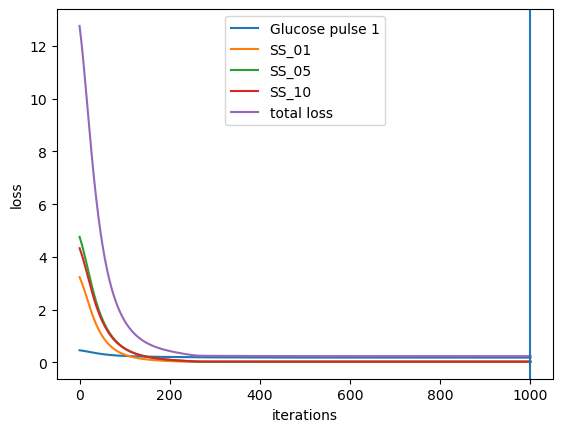

In [35]:
# pd.DataFrame(pd.Series(new_params)).to_csv("1000iterations_params.csv")
plt.plot(losses_per_iterations['loss_per_iter1'],label="Glucose pulse 1")
plt.plot(losses_per_iterations['loss_per_iter2'],label="SS_01")

plt.plot(losses_per_iterations['loss_per_iter3'],label="SS_05")
plt.plot(losses_per_iterations['loss_per_iter4'],label="SS_10")
# plt.plot(losses_per_iterations['loss_per_iter5'],label="SS_20")
# plt.plot(losses_per_iterations['loss_per_iter6'],label="SS_30")
# plt.plot(losses_per_iterations['loss_per_iter7'],label="SS_32")
# plt.plot(losses_per_iterations['loss_per_iter8'],label="SS_35")
# plt.plot(losses_per_iterations['loss_per_iter9'],label="SS_375")



plt.plot(losses_per_iterations_added.sum(axis=1),label="total loss")
plt.axvline(np.argmin(losses_per_iterations_added.sum(axis=1)))
# plt.axvline(np.argmin(losses_per_iterations['loss_per_iter8']))
plt.ylabel("loss")
# plt.yscale("log")
plt.legend()
plt.xlabel("iterations")


Array(0.17478831, dtype=float64)

In [37]:
def give_steady_states(model,params_init,y0):
    ts=jnp.linspace(0,3000,1000)
    metabolite_names=list(y0.keys())
    ys_pred=model(ts,jnp.array(list(y0.values())),params_init)

    ys_final_steady_state=ys_pred[-1,:]
    ys_final_steady_state=dict(zip(metabolite_names,ys_final_steady_state))
    return ys_final_steady_state


In [38]:
y0_SS_375

{'ICG1P': 0.1,
 'ICT6P': 0.015,
 'ICtreh': 63.31204,
 'ICglucose': 0.196003,
 'ICG6P': 3.505,
 'ICF6P': 0.438,
 'ICFBP': 0.00595,
 'ICDHAP': 0.6865,
 'ICG3P': 0.11,
 'ICglyc': 0.1,
 'ICGAP': 0.0215,
 'ICBPG': 0.0001,
 'IC3PG': 1.0,
 'IC2PG': 0.297534,
 'ICPEP': 0.095,
 'ICPYR': 3.7,
 'ICACE': 0.04,
 'ICETOH': 54.05,
 'ICNADH': 0.0283928571428571,
 'ICNAD': 1.56160714285714,
 'ICATP': 2.9025,
 'ICADP': 0.4795,
 'ICAMP': 0.112,
 'ICPHOS': 10,
 'ICIMP': 0.1,
 'ICINO': 0.1,
 'ICHYP': 1.5}

In [40]:
params_01=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.01))
params_05=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.05))
params_10=log_transform_parameters(update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.1))

D01_SS=give_steady_states(glycolyse_SS_10,params_init,y0_SS_10)
D05_SS=give_steady_states(glycolyse_SS_05,params_init,y0_SS_05)
D10_SS=give_steady_states(glycolyse_SS_10,params_init,y0_SS_10)
# D20_SS=give_steady_states(glycolyse_SS_20,params_init,y0_SS_20)
# D30_SS=give_steady_states(glycolyse_SS_30,params_init,y0_SS_30)
# D325_SS=give_steady_states(glycolyse_SS_325,params_init,y0_SS_325)
# D35_SS=give_steady_states(glycolyse_SS_35,params_init,y0_SS_35)
# D375_SS=give_steady_states(glycolyse_SS_375,params_init,y0_SS_375)

In [ ]:
D375_SS['ICETOH']

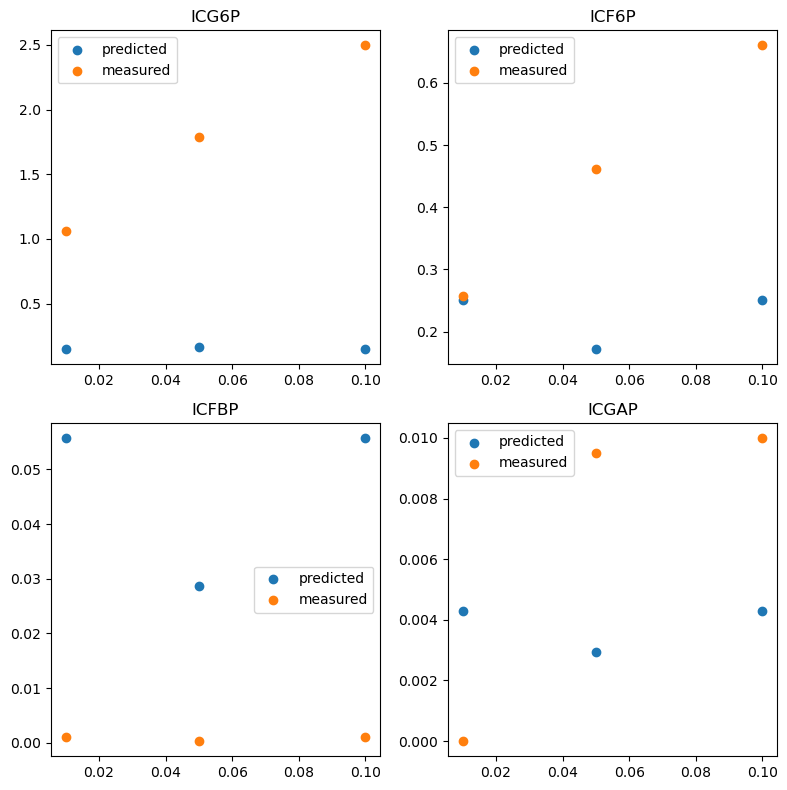

In [44]:
Dilutions=[0.01,0.05,0.1,0.2,0.3,0.325,0.350,0.375]


# Creating a 4x4 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
metabolites=["ICG6P","ICF6P","ICPYR","ICETOH"]
# Loop through metabolites to generate plots
for i, metabolite in enumerate(metabolites):  # Adjust the range as necessary
    row, col = divmod(i, 2)
    ax = axs[row, col]

    measured = [y0_SS_01[metabolite], y0_SS_05[metabolite], y0_SS_10[metabolite], y0_SS_20[metabolite],
                y0_SS_30[metabolite], y0_SS_325[metabolite], y0_SS_35[metabolite], y0_SS_375[metabolite]]
    
    SS_values = [D01_SS[metabolite], D05_SS[metabolite], D10_SS[metabolite], D20_SS[metabolite],
                 D30_SS[metabolite], D325_SS[metabolite], D35_SS[metabolite], D375_SS[metabolite]]
    
    ax.scatter(Dilutions, SS_values, label="predicted")
    ax.scatter(Dilutions, measured, label="measured")
    
    ax.set_title(metabolite)
    ax.set_ylim(0, max(max(measured), max(SS_values)) * 1.2)  # Adjust ylim dynamically
    ax.legend()

plt.tight_layout()
plt.show()

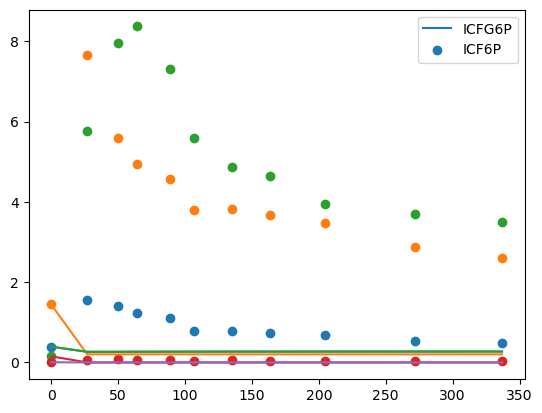

In [32]:
y0_GP1['ICglyc']=0.1

GP1_params=update_parameters_by_dilution_rate(params_init,interpolation_expression_dict,D=0.1)
ys=glycolyse_GP1(time_points_GP1,y0=jnp.array(list(y0_GP1.values())),params=GP1_params)
ys=pd.DataFrame(ys,columns=metabolite_names)
plt.plot(time_points_GP1,ys['ICF6P'],label="ICFG6P")
plt.plot(time_points_GP1,ys['ICG6P'])
plt.plot(time_points_GP1,ys['ICF6P'])
plt.plot(time_points_GP1,ys['ICFBP'])
plt.plot(time_points_GP1,ys['ICGAP'])
plt.scatter(time_points_GP1,dataset_GP1['ICF6P'],label="ICF6P")
plt.scatter(time_points_GP1,dataset_GP1['ICG6P'])
plt.scatter(time_points_GP1,dataset_GP1['ICFBP'])
plt.scatter(time_points_GP1,dataset_GP1['ICGAP'])
plt.legend()